In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 11 October 2024

# Compare to catalog in Siegfried et al., 2016
# https://doi.org/10.1002/2016GL067758

# Produces statistics used in Section XX of Katz et al., 2024
# DOI HERE

# Imports
import os
import pandas as pd
import numpy as np
import scipy
from PyAstronomy import pyasl
import datetime
from collections import Counter

import src.Catalog.Catalog as Catalog

In [2]:
# Load events into dataframe
data = {"event": [], "trace_time": []}
folders = [
    "2008_2008Events_2stas",
    "2009_2009Events_2stas",
    "2010_2010Events_2stas",
    "2011_2011Events_2stas",
    "2012_2012Events_2stas",
    "2013_2013Events_2stas",
    "2014_2014Events_2stas",
    "2015_2015Events_2stas",
    "2016_2016Events_2stas",
    "2017_2017Events_2stas",
    "2018_2018Events_2stas",
    "2019_2019Events_2stas",
]
for folder in folders:
    for file in os.listdir(folder):
        df = pd.read_csv(f"{folder}/{file}", sep="\t")
        data["event"].append(df)
        data["trace_time"].append(file[:-4])

In [3]:
def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad2 - Second derivative [list]
    """

    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


def derivative2(time, grad, order, crit, spacing):
    # 2nd derivative
    b, a = scipy.signal.butter(order, crit)
    grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
    grad2 = np.gradient(grad_filtered, spacing)

    return grad2

In [4]:
# Compute average second derivatives of all traces for each event
avg_grad2s = []
for event in data["event"][:]:
    x_cols = [col for col in event if col.endswith("x")]
    grad2s = []
    # print(len(event['time']),event['time'][0])
    for x_col in x_cols:
        grad = derivative(event["time"], event[x_col], 4, 0.1, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
    avg_grad2s.append(np.nanmean(grad2s, axis=0))
data["grad2"] = avg_grad2s

# Compute index of max
max_index = [np.argmax(i) for i in data["grad2"]]
data["grad2maxIndex"] = max_index

# Calculate event start times based on 2nd derivative
data["ev_time"] = [
    data["event"][i]["time"][data["grad2maxIndex"][i]]
    for i in range(len(data["event"]))
]

In [19]:
# Print to catalog
ev_time_datetime = [
    datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in data["ev_time"]
]
ev_time_decimal = [pyasl.decimalYear(i) for i in ev_time_datetime]
with open("CatalogSlipDecimalYear.txt", "w") as f:
    f.write("SlipTime\n")
    for time in ev_time_decimal:
        f.write(f"{time}\n")

In [20]:
# Compare catalogs
catalog = pd.read_csv("CatalogSlipDecimalYear.txt", sep="\t")
matt_catalog = pd.read_csv("allslip20102014.dat", sep=",", index_col=None)
data_times = pd.read_csv("no_data_2stas.txt", sep="\t")

# Convert data times to decimal
start_times_datetime = [
    datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in data_times["start"]
]
start_times_decimal = [pyasl.decimalYear(i) for i in start_times_datetime]

end_times_datetime = [
    datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in data_times["end"]
]
end_times_decimal = [pyasl.decimalYear(i) for i in end_times_datetime]

for stime, etime in zip(start_times_decimal, end_times_decimal):
    catalog = catalog[~catalog["SlipTime"].between(stime, etime)]
    matt_catalog = matt_catalog[
        ~matt_catalog["StartTime"].between(stime, etime)
    ].reset_index(drop=True)
catalog = catalog[
    catalog["SlipTime"].between(
        matt_catalog["StartTime"].iloc[0], matt_catalog["StartTime"].iloc[-1]
    )
]

# Convert back to datetimes
matt_catalog["StartTime"] = [
    pyasl.decimalYearGregorianDate(i) for i in matt_catalog["StartTime"]
]
catalog["SlipTime"] = [pyasl.decimalYearGregorianDate(i) for i in catalog["SlipTime"]]

In [29]:
# Loop over my and Matt's events to associate
assoc_window = 2

print(f"Association Window: {assoc_window} Hours")
x = 0
matt_assocs = []
my_assocs = []
for i in range(len(catalog["SlipTime"])):
    for j in range(len(matt_catalog["StartTime"])):
        if abs(
            catalog["SlipTime"].iloc[i] - matt_catalog["StartTime"].iloc[j]
        ) < datetime.timedelta(hours=assoc_window):
            matt_assocs.append(j)
            my_assocs.append(i)

comp = np.arange(0, len(matt_catalog["StartTime"]), 1)

missed = np.setdiff1d(comp, matt_assocs)
missed_percent = len(missed) / len(matt_catalog["StartTime"]) * 100
print(
    f"Missed Events in Matt's Catalog: {len(missed)}, {missed_percent:.2f}% of Matt's Detections."
)
# print(missed)

comp2 = np.arange(0, len(catalog["SlipTime"]), 1)
extra = np.setdiff1d(comp, my_assocs)

d = Counter(matt_assocs)
rep = list([item for item in d if d[item] > 1])

print(f"Extra Events in My Catalog Doubly Associated with Matt's Events: {len(rep)}")
# print(rep)

# Calculate total extra events
tot = len(catalog["SlipTime"]) - len(matt_catalog["StartTime"])
tot_per = tot / len(catalog["SlipTime"]) * 100
print(f"Total Extra Events: {tot}, {tot_per:.2f}% of My Detections")

Association Window: 2 Hours
Missed Events in Matt's Catalog: 3, 0.11% of Matt's Detections.
Extra Events in My Catalog Doubly Associated with Matt's Events: 0
Total Extra Events: 1, 0.04% of My Detections


In [30]:
# Set to print all events
print(len(matt_catalog["StartTime"]))
pd.set_option("display.max_rows", None)
print(matt_catalog["StartTime"])

2708
0      2010-01-01 16:21:29.000998
1      2010-01-02 00:53:00.000004
2      2010-01-02 18:13:59.000997
3      2010-01-03 17:19:30.000000
4      2010-01-04 00:21:52.000825
5      2010-01-04 15:53:30.000000
6      2010-01-05 01:01:19.000352
7      2010-01-05 15:25:29.000998
8      2010-01-06 02:58:29.000996
9      2010-01-06 15:53:30.000002
10     2010-01-07 16:28:29.000996
11     2010-01-08 10:30:59.000996
12     2010-01-08 18:36:29.000998
13     2010-01-09 10:08:29.000996
14     2010-01-09 18:42:29.000999
15     2010-01-10 11:10:30.000000
16     2010-01-10 19:46:00.000954
17     2010-01-11 12:29:59.000996
18     2010-01-11 21:15:55.000510
19     2010-01-12 13:42:30.000005
20     2010-01-12 22:34:30.000000
21     2010-01-13 15:06:00.000002
22     2010-01-14 00:40:46.000715
23     2010-01-14 16:02:41.000878
24     2010-01-15 17:22:44.000996
25     2010-01-16 04:50:44.000998
26     2010-01-16 18:22:00.000001
27     2010-01-17 17:14:45.000000
28     2010-01-18 03:50:45.000005
29     20

Missed Events:
2010-08-16 00:09:14.000254
2014-06-28 18:03:30.000004
2014-12-31 20:59:15.000002
Extra Events:
2009-03-28 15:16:15
2009-04-07 08:36:30
2009-04-09 09:22:30
2012-08-13 08:43:00


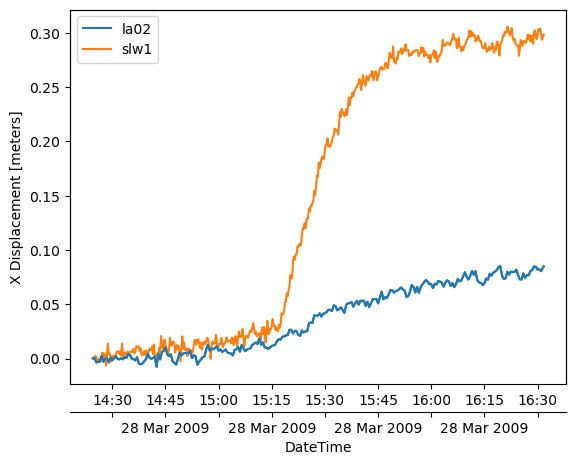

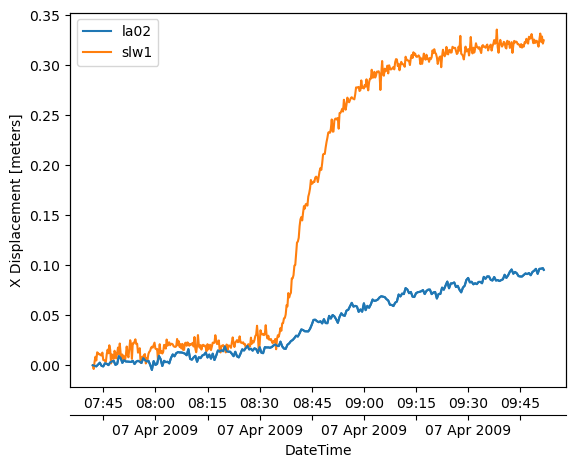

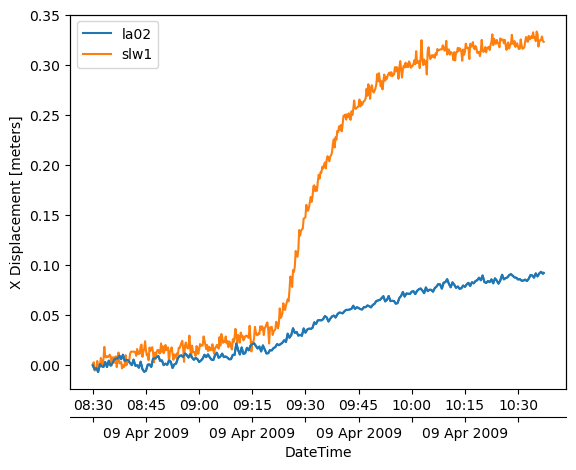

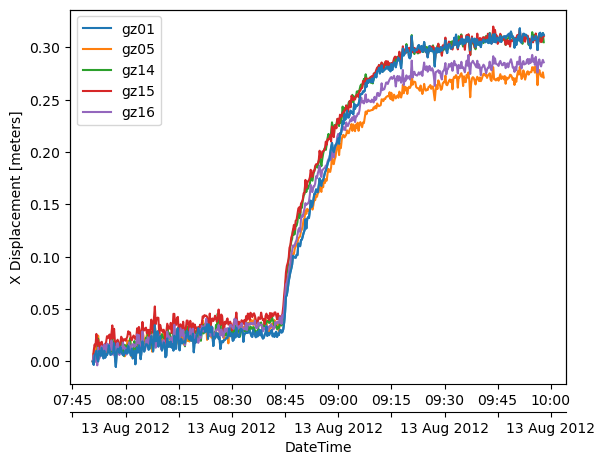

In [31]:
# Find times of missed events
print("Missed Events:")
for i in missed:
    st = matt_catalog["StartTime"][i]
    print(st)

# Plot all extra events
# Find event number of extra event
print("Extra Events:")
extra = np.setdiff1d(comp, my_assocs)
for event_num in extra:
    event = data["event"][event_num]
    print(data["ev_time"][event_num])
    Catalog.plot_event(event)